In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir("..")

In [10]:
import numpy as np
import matplotlib.pyplot as plt

from numpy.typing import NDArray

In [13]:
from qml.model.gate import get_gateset
from qml.model.model import Model
from qml.model.unit import Unit, EmbedUnit
from qml.tools.evaluator import Evaluator
from qml.tools.dataset import generate_dataset

In [5]:
%matplotlib inline

## Parameter

In [7]:
# circuit
num_qubits = nq = 2
num_gate_per_unit = ng = 3
num_unit_per_round = nu = 9

# dataset
dim_input = nx = 1
dim_output = ny = 1
num_train_data = 20
num_test_data = 20
gateset = get_gateset(nq)

# optimization
shots = 50
num_max_iter = 100
var_to_explore = 0.3

## Dataset

In [6]:
target_func = lambda x: np.sin(np.pi * x)

In [8]:
train_data = generate_dataset(num_train_data, target_func)
test_data  = generate_dataset(num_test_data,  target_func)

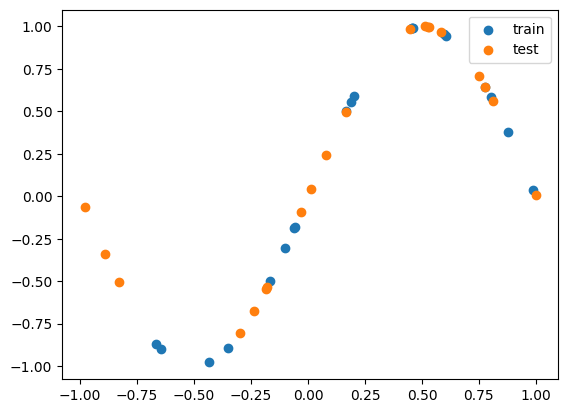

In [9]:
fig, ax = plt.subplots()
ax.scatter(*train_data.data, label="train")
ax.scatter(*test_data.data, label="test")
plt.legend()

In [44]:
class ErrorPattern:

    def __init__(self, loss, pattern, predics, xs, ys):
        self.loss = loss
        self.pattern = pattern
        self.ps = predics
        self.xs = xs
        self.ys = ys
    
    def draw_pattern(self, show_predict=False, show_y=False, ax=None):
        if ax is None:
            fig, ax = plt.subplots()
        
        ax.scatter(self.xs, self.pattern, label="error")
        if show_predict:
            ax.scatter(self.xs, self.ps, label="predict")
        if show_y:
            ax.scatter(self.xs, self.ys, label="y")
        ax.legend()

        return fig, ax

In [51]:
class ErrorPatternEvaluator(Evaluator):
    
    def __init__(
            self,
            xs: NDArray,
            ys: NDArray,
            model: Model = None,
            shots: int = 50
    ):
        super().__init__(xs, ys, model, shots)

    def __call__(
            self,
            params: NDArray = None,
            model: Model = None,
    ) -> ErrorPattern:
        if model is None:
            model = self._model
        return self.evaluate(
            model, params, self._xs, self._ys, shots=self.shots
        )
    
    def evaluate(
            cls,
            model: Model,
            params: NDArray,
            xs: NDArray,
            ys: NDArray,
            shots: int = 50,
    ) -> ErrorPattern:
        predicts = np.asarray([
            model.forward(x, params=params, shots=shots)
            for x in xs
        ])
        errors = predicts - ys
        loss = np.square(errors).mean()
        return ErrorPattern(loss, errors, predicts, xs, ys)

In [52]:
emb_unit = EmbedUnit.generate_ry_arcsin_embed_unit("emb", nq, nx, gateset)

In [53]:
model = Model(nq, ny, emb_unit, [], [])

In [54]:
evaluator = ErrorPatternEvaluator(train_data.xs, train_data.ys, model, shots=shots)

In [55]:
ep = evaluator()

(<Figure size 640x480 with 1 Axes>, <Axes: >)

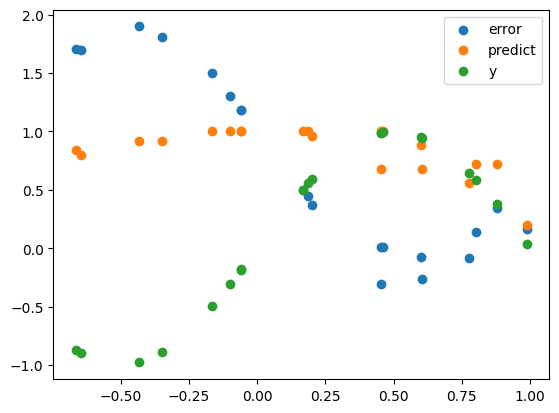

In [56]:
ep.draw_pattern(show_predict=True, show_y=True)